In [1]:
import os
os.chdir("D:/my_py_packages/supplyseer")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from src.supplyseer.experimental.exotic_supplychain.supplychaingraphs import SupplyChainNetwork, SupplyChainNode

### Physics-Inspired Supply Chain (PISC)

Potential Energy -> Stored Inventory
* Physics: objects at heigh have stored energy due to their position
* Supply Chain: 
  * High inventory levels are like stored potential energy
  * Assumption: like a ball wants to roll downhill -> inventory "wants" to flow from high to low stock levels
  * Creates a natural pressure to balance inventory across locations
<br>

Diffusion -> Natural Inventory Flow (balancing)
* Physics: heat/particles naturally move from high to low concentration
* Supply Chain:
  * Inventory naturally wants to spread out evenly across warehouses when there is no plan/constraint
  * If one warehouse has 100 items and a retail store has 10, there's a natural business pressure to move it to the store
  * Diffusion coefficient represents how quickly this happens
<br>

Magnetic Forces -> Demand Pull
* Physics: Magnets create attractive forces
* Supply Chain:
  * Customer demand acts like a magnetic force pulling inventory
  * Higher demand creates stronger pull on inventory
  * The force gets stronger as the destination's inventory gets lower (like magnetic field strength with distance)
<br>

Flow Rates & Capacity -> Transport Constraints
* Physics: Fluid flow through pipes has maximum rates
* Supply Chain:
  * Transport links have maximum daily shipping capacity
  * Like a pipe that can only handle so much flow
  * The max_flow_rate parameter represents truck/shipping capacity
<br>

Kinetic Energy -> Inventory Movement
* Physics: Energy of motion
* Supply Chain:
  * Represents actual movement of goods through the network
  * Higher when there's lots of shipping activity
  * Lower when the system reaches equilibrium
<br>

Conservation Laws -> Inventory Tracking
* Physics: Mass/energy cannot be created or destroyed
* Supply Chain:
  * Each item that leaves one location must either:
    * Arrive at another location
    * Be sold to a customer
    * Be counted as lost/damaged leading to a write-off
  * Total inventory only changes through external sales or replenishment
<br>




Timestep 0: 2023-01-01 00:00:00
Flow from Warehouse A to Retail Store C: 25.00
Flow from Warehouse B to Retail Store C: 20.00
Flow from Warehouse A to Warehouse B: 6.00
Warehouse A: Stock Level = 69.00
Warehouse B: Stock Level = 66.00
Retail Store C: Stock Level = 55.00

Timestep 1: 2023-01-02 00:00:00
Flow from Warehouse A to Retail Store C: 25.00
Flow from Warehouse B to Retail Store C: 4.69
Flow from Warehouse A to Warehouse B: -6.92
Warehouse A placed order for 49.08 units, arriving in 2 days
Warehouse A: Stock Level = 50.92
Warehouse B: Stock Level = 54.39
Retail Store C: Stock Level = 64.69

Timestep 2: 2023-01-03 00:00:00
Flow from Warehouse A to Retail Store C: 4.64
Flow from Warehouse B to Retail Store C: 3.97
Flow from Warehouse A to Warehouse B: -1.65
Warehouse A placed order for 52.06 units, arriving in 2 days
Warehouse B placed order for 31.24 units, arriving in 1 days
Warehouse A: Stock Level = 47.94
Warehouse B: Stock Level = 48.76
Retail Store C: Stock Level = 53.30

T

D:\my_py_packages\supplyseer\src\supplyseer\experimental\exotic_supplychain\supplychaingraphs.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '49.07636363636364' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.results.iloc[current_timestamp_idx, self.results.columns.get_loc('ordered_amount')] = order_amount
D:\my_py_packages\supplyseer\src\supplyseer\experimental\exotic_supplychain\supplychaingraphs.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '31.238251943365533' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.results.iloc[current_timestamp_idx, self.results.columns.get_loc('ordered_amount')] = order_amount


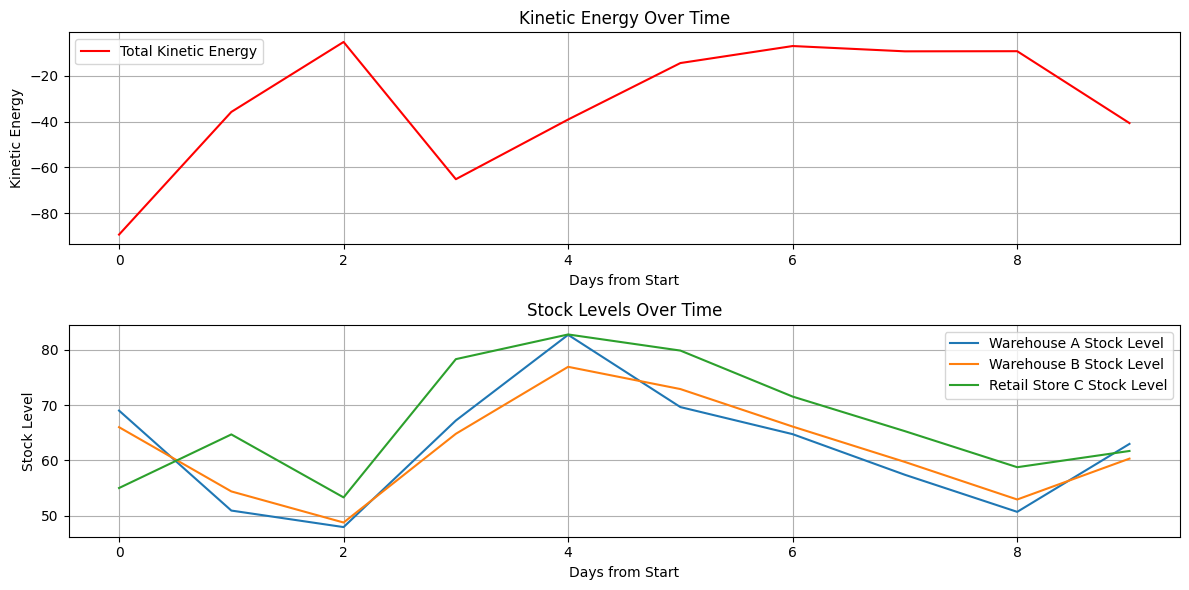

In [13]:
index = pd.date_range(start='2023-01-01', periods=10, freq='D')

# Create DataFrames with replenishment configuration
warehouse_a_df = pd.DataFrame({
    'stock_level': [100] * 10,
    'sales_demand': [0] * 10,
    'reorder_point': [60] * 10,  # Order when stock falls below 60
    'target_stock': [100] * 10,  # Restock to 100
    'replenishment_lead_time': [2] * 10  # 2 days to receive new stock
}, index=index)

warehouse_b_df = pd.DataFrame({
    'stock_level': [80] * 10,
    'sales_demand': [0] * 10,
    'reorder_point': [50] * 10,  # Order when stock falls below 50
    'target_stock': [80] * 10,   # Restock to 80
    'replenishment_lead_time': [1] * 10  # 1 day to receive new stock
}, index=index)

retail_store_c_df = pd.DataFrame({
    'stock_level': [30] * 10,
    'sales_demand': [20] * 10
}, index=index)

# Create nodes
nodes = {
    'Warehouse A': SupplyChainNode('Warehouse A', warehouse_a_df),
    'Warehouse B': SupplyChainNode('Warehouse B', warehouse_b_df),
    'Retail Store C': SupplyChainNode('Retail Store C', retail_store_c_df)
}

# Define edges
edges = {
    ('Warehouse A', 'Retail Store C'): {'potential': 0.4, 'max_flow_rate': 25},
    ('Warehouse B', 'Retail Store C'): {'potential': 0.5, 'max_flow_rate': 20},
    ('Warehouse A', 'Warehouse B'): {'potential': 0.3, 'max_flow_rate': 15}
}

# Create and simulate network
network = SupplyChainNetwork(nodes, edges)
network.simulate_flow()

In [3]:
class SupplyChainNode2:
    def __init__(self, name, dataframe):
        self.name = name
        self.timestamps = dataframe.index
        
        # Initial stock level
        self.stock_level = dataframe['stock_level'].iloc[0]
        
        # Store demand and sales data
        self.forecast_demand = dataframe['forecast_demand'].values if 'forecast_demand' in dataframe else np.zeros(len(dataframe))
        self.actual_sales = dataframe['actual_sales'].values if 'actual_sales' in dataframe else np.zeros(len(dataframe))
        
        # Reorder parameters (from original code)
        self.reorder_point = (dataframe['reorder_point'].iloc[0] 
                            if 'reorder_point' in dataframe 
                            else self.stock_level * 0.5)
        self.target_stock = (dataframe['target_stock'].iloc[0] 
                           if 'target_stock' in dataframe 
                           else self.stock_level)
        self.replenishment_lead_time = (dataframe['replenishment_lead_time'].iloc[0] 
                                      if 'replenishment_lead_time' in dataframe 
                                      else 1)
        self.pending_orders = []
        
        # Results DataFrame with expanded columns
        self.results = pd.DataFrame(index=dataframe.index, 
                                  columns=['stock_level', 
                                         'forecast_demand',
                                         'actual_sales',
                                         'unused_potential',
                                         'potential_energy',
                                         'ordered_amount'])
        
        # Initialize results
        self.results['stock_level'].iloc[0] = self.stock_level
        self.results['forecast_demand'] = self.forecast_demand
        self.results['actual_sales'] = self.actual_sales
        self.results['ordered_amount'] = 0
        
        # Calculate initial unused potential
        self.calculate_unused_potential(0)

    def check_and_place_order(self, current_timestamp_idx):
        """Check if we need to place a replenishment order"""
        current_stock = float(self.results.iloc[current_timestamp_idx]['stock_level'])
        
        if current_stock <= self.reorder_point:
            order_amount = self.target_stock - current_stock
            arrival_time = current_timestamp_idx + self.replenishment_lead_time
            self.pending_orders.append((arrival_time, order_amount))
            self.results.iloc[current_timestamp_idx, self.results.columns.get_loc('ordered_amount')] = order_amount
            print(f"{self.name} placed order for {order_amount:.2f} units, arriving in {self.replenishment_lead_time} days")


    def process_pending_orders(self, current_timestamp_idx):
        """Process any pending orders that have arrived"""
        arrived_orders = [order for order in self.pending_orders if order[0] <= current_timestamp_idx]
        self.pending_orders = [order for order in self.pending_orders if order[0] > current_timestamp_idx]
        
        total_arrived = sum(order[1] for order in arrived_orders)
        if total_arrived > 0:
            self.update_inventory(incoming=total_arrived, outgoing=0, timestamp_idx=current_timestamp_idx)
            print(f"{self.name} received {total_arrived:.2f} units from external supplier")

    def calculate_potential_energy(self, timestamp_idx):
        """Calculate potential energy using numeric index"""
        stock_level = self.results.iloc[timestamp_idx]['stock_level']
        potential_energy = stock_level * 0.5
        self.results.iloc[timestamp_idx, self.results.columns.get_loc('potential_energy')] = potential_energy
        
    def calculate_unused_potential(self, timestamp_idx):
        """Calculate unused demand potential"""
        available = self.results.iloc[timestamp_idx]['stock_level']
        sales = self.results.iloc[timestamp_idx]['actual_sales']
        unused = max(0, available - sales)
        self.results.iloc[timestamp_idx, self.results.columns.get_loc('unused_potential')] = unused
        return unused
        
    def update_inventory(self, incoming, outgoing, timestamp_idx):
        """Update inventory with incoming and outgoing flows"""
        current_inventory = self.results.iloc[timestamp_idx]['stock_level']
        net_flow = incoming - outgoing
        new_inventory = max(current_inventory + net_flow, 0)  # Prevent negative inventory
        
        self.results.iloc[timestamp_idx, self.results.columns.get_loc('stock_level')] = new_inventory
        self.calculate_potential_energy(timestamp_idx)
        self.calculate_unused_potential(timestamp_idx)
        
        return net_flow

In [153]:
class SupplyChainNetwork2:
    def __init__(self, nodes, edges):
        self.nodes = nodes
        self.edges = edges
        
        # New tracking for network-wide metrics
        self.network_metrics = pd.DataFrame(index=next(iter(nodes.values())).timestamps,
                                          columns=['total_forecast_demand',
                                                 'total_actual_sales',
                                                 'total_unused_potential',
                                                 'system_kinetic_energy'])
    
    def calculate_edge_potential(self, from_node, to_node, timestamp_idx):
        """Calculate potential between nodes considering demand and unused potential"""
        base_potential = self.edges[(from_node, to_node)]['potential']
        
        # Get demand metrics for destination node
        to_node_obj = self.nodes[to_node]
        forecast = to_node_obj.results.iloc[timestamp_idx]['forecast_demand']
        unused = to_node_obj.results.iloc[timestamp_idx]['unused_potential']
        current_stock = to_node_obj.results.iloc[timestamp_idx]['stock_level']
        
        # Adjust potential based on forecast and unused potential
        demand_factor = forecast / (current_stock + 1)  # Higher when stock is low
        unused_factor = 1 - (unused / (current_stock + 1))  # Lower when unused potential is high
        
        return base_potential * demand_factor * unused_factor
    
    def simulate_flow(self):
        timesteps = next(iter(self.nodes.values())).timestamps
        num_steps = len(timesteps)
        
        kinetic_energy_history = []
        time_deltas = []
        initial_time = timesteps[0]
        
        for t in range(num_steps):
            if t > 0:
                # Copy previous state
                for node in self.nodes.values():
                    prev_stock = node.results.iloc[t-1]['stock_level']
                    node.results.iloc[t, node.results.columns.get_loc('stock_level')] = prev_stock
            
            print(f"\nTimestep {t}: {timesteps[t]}")
            total_kinetic_energy = 0
            
            time_delta = (timesteps[t] - initial_time).total_seconds() / (24 * 3600)
            time_deltas.append(time_delta)
            
            # Process pending orders
            for node in self.nodes.values():
                node.process_pending_orders(t)
            
            # Process actual sales for all nodes
            for node_name, node in self.nodes.items():
                actual_sales = node.actual_sales[t]
                if actual_sales > 0:
                    node.update_inventory(incoming=0, outgoing=actual_sales, timestamp_idx=t)
            
            # Calculate and apply flows between nodes
            for (from_node, to_node), edge_data in self.edges.items():
                edge_potential = self.calculate_edge_potential(from_node, to_node, t)
                max_flow_rate = edge_data['max_flow_rate']
                
                # Calculate flows considering demand potential
                from_stock = self.nodes[from_node].results.iloc[t]['stock_level']
                to_stock = self.nodes[to_node].results.iloc[t]['stock_level']
                
                inventory_difference = from_stock - to_stock
                base_flow = edge_potential * inventory_difference
                diffusion_flow = self.calculate_diffusion_flow(from_node, to_node, t)
                total_flow = np.clip(base_flow + diffusion_flow, -max_flow_rate, max_flow_rate)
                
                if abs(total_flow) > 0.01:
                    # Update nodes
                    self.nodes[from_node].update_inventory(0, total_flow, t)
                    self.nodes[to_node].update_inventory(total_flow, 0, t)
                    
                    # Calculate energy
                    delta_kinetic_energy = -total_flow * edge_potential
                    total_kinetic_energy += delta_kinetic_energy
            
            # Update network-wide metrics
            self.network_metrics.iloc[t] = [
                sum(node.results.iloc[t]['forecast_demand'] for node in self.nodes.values()),
                sum(node.results.iloc[t]['actual_sales'] for node in self.nodes.values()),
                sum(node.results.iloc[t]['unused_potential'] for node in self.nodes.values()),
                total_kinetic_energy
            ]
            
            kinetic_energy_history.append(total_kinetic_energy)
            
            # Check and place orders for warehouses
            for node in self.nodes.values():
                if 'Warehouse' in node.name:
                    node.check_and_place_order(t)
        
        self.plot_results(time_deltas, kinetic_energy_history)

    def calculate_diffusion_flow(self, from_node, to_node, timestamp_idx, diffusion_coefficient=0.1):
        """Calculate diffusion flow using numeric index"""
        from_stock = self.nodes[from_node].results.iloc[timestamp_idx]['stock_level']
        to_stock = self.nodes[to_node].results.iloc[timestamp_idx]['stock_level']
        
        inventory_difference = from_stock - to_stock
        diffusion_flow = diffusion_coefficient * inventory_difference
        
        return np.clip(diffusion_flow, -from_stock, to_stock)
    
    def get_filtered_metrics(self, filter_string='store'):
        """
        Get metrics for nodes whose names contain the filter string
        """
        filtered_nodes = {name: node for name, node in self.nodes.items() 
                         if filter_string.lower() in name.lower()}
        
        if not filtered_nodes:
            print(f"No nodes found containing '{filter_string}'")
            return None
        
        # Create DataFrame with metrics for filtered nodes
        metrics_df = pd.DataFrame(index=self.network_metrics.index)
        
        # Aggregate metrics for filtered nodes
        metrics_df['forecast_demand'] = sum(node.results['forecast_demand'] 
                                          for node in filtered_nodes.values())
        metrics_df['actual_sales'] = sum(node.results['actual_sales'] 
                                       for node in filtered_nodes.values())
        metrics_df['unused_potential'] = sum(node.results['unused_potential'] 
                                           for node in filtered_nodes.values())
        metrics_df['total_stock'] = sum(node.results['stock_level'] 
                                      for node in filtered_nodes.values())
        
        # Add node-specific columns
        for name, node in filtered_nodes.items():
            metrics_df[f'{name}_stock'] = node.results['stock_level']
            metrics_df[f'{name}_forecast'] = node.results['forecast_demand']
            metrics_df[f'{name}_sales'] = node.results['actual_sales']
            metrics_df[f'{name}_unused'] = node.results['unused_potential']
        
        return metrics_df

    def plot_filtered_results(self, filter_string='store', time_deltas=None):
        """
        Plot results for nodes whose names contain the filter string
        """
        metrics_df = self.get_filtered_metrics(filter_string)
        if metrics_df is None:
            return
        
        if time_deltas is None:
            time_deltas = range(len(metrics_df))

        plt.figure(figsize=(15, 12))
        
        # Plot 1: Aggregated Metrics
        plt.subplot(3, 1, 1)
        plt.plot(time_deltas, metrics_df['forecast_demand'], 
                label='Total Forecast Demand', color='b')
        plt.plot(time_deltas, metrics_df['actual_sales'], 
                label='Total Actual Sales', color='g')
        plt.plot(time_deltas, metrics_df['unused_potential'], 
                label='Total Unused Potential', color='r', linestyle='--')
        plt.xlabel('Days from Start')
        plt.ylabel('Units')
        plt.title(f'Aggregated Metrics for {filter_string.title()} Nodes')
        plt.legend()
        plt.grid(True)
        
        # Plot 2: Individual Stock Levels
        plt.subplot(3, 1, 2)
        stock_columns = [col for col in metrics_df.columns if 'stock' in col]
        for col in stock_columns:
            plt.plot(time_deltas, metrics_df[col], 
                    label=col.replace('_stock', ''))
        plt.xlabel('Days from Start')
        plt.ylabel('Stock Level')
        plt.title(f'Individual Stock Levels for {filter_string.title()} Nodes')
        plt.legend()
        plt.grid(True)
        
        # Plot 3: Sales vs Forecast Comparison
        plt.subplot(3, 1, 3)
        filtered_nodes = [name for name in self.nodes.keys() 
                         if filter_string.lower() in name.lower()]
        
        for node_name in filtered_nodes:
            plt.plot(time_deltas, metrics_df[f'{node_name}_forecast'], 
                    label=f'{node_name} Forecast', linestyle='--')
            plt.plot(time_deltas, metrics_df[f'{node_name}_sales'], 
                    label=f'{node_name} Actual')
        plt.xlabel('Days from Start')
        plt.ylabel('Units')
        plt.title(f'Forecast vs Actual Sales for {filter_string.title()} Nodes')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

    def get_node_metrics(self, node_name):
        """
        Get detailed metrics for a specific node
        """
        if node_name not in self.nodes:
            print(f"Node '{node_name}' not found")
            return None
            
        node = self.nodes[node_name]
        return {
            'data': node.results,
            'summary': {
                'avg_forecast': node.results['forecast_demand'].mean(),
                'avg_sales': node.results['actual_sales'].mean(),
                'avg_unused': node.results['unused_potential'].mean(),
                'min_stock': node.results['stock_level'].min(),
                'max_stock': node.results['stock_level'].max(),
                'stockout_days': (node.results['stock_level'] == 0).sum()
            }
        }

    def visualize_network(self, figsize=(14, 8), with_labels=True):
        G = nx.DiGraph()
        
        # Add nodes - keep original sizes
        for node_name, node in self.nodes.items():
            current_stock = node.results['stock_level'].iloc[-1]
            G.add_node(node_name, 
                    stock_level=current_stock,
                    type='Warehouse' if 'Warehouse' in node_name else 'Store')
        
        # Add edges
        for (from_node, to_node), edge_data in self.edges.items():
            G.add_edge(from_node, to_node, 
                    max_flow_rate=edge_data['max_flow_rate'],
                    potential=edge_data['potential'])
        
        plt.figure(figsize=figsize)
        
        # Keep original node sizes
        node_colors = ['lightblue' if 'Warehouse' in node else 'lightgreen' 
                    for node in G.nodes()]
        node_sizes = [1000 + float(G.nodes[node]['stock_level']) * 10 
                    for node in G.nodes()]
        
        # Increase spacing between nodes
        pos = nx.spring_layout(G, k=1)
        
        # Calculate edge properties
        edge_props = []
        for _, _, edge_data in G.edges(data=True):
            edge_props.append((edge_data['max_flow_rate'], edge_data['potential']))
        
        max_flow_max = max(ep[0] for ep in edge_props) if edge_props else 1
        potential_max = max(ep[1] for ep in edge_props) if edge_props else 1
        
        edge_widths = [1.0 + (ep[0] / max_flow_max) * 5 for ep in edge_props]
        edge_alphas = [0.2 + (ep[1] / potential_max) * 0.8 for ep in edge_props]
        
        # Draw edges with larger margins and more curve
        for i, (from_node, to_node) in enumerate(G.edges()):
            nx.draw_networkx_edges(G, pos,
                                edgelist=[(from_node, to_node)],
                                width=edge_widths[i],
                                alpha=edge_alphas[i],
                                edge_color='red',
                                arrows=True,
                                arrowsize=35,  # Larger arrows
                                arrowstyle='-|>',
                                connectionstyle='arc3,rad=0.1',  # More curve
                                min_source_margin=30,  # Larger margin from source
                                min_target_margin=30)  # Larger margin from target
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, 
                            node_color=node_colors,
                            node_size=node_sizes)
        
        if with_labels:
            # Node labels
            node_labels = {node: f"{node}\n(Stock: {G.nodes[node]['stock_level']:.0f})"
                        for node in G.nodes()}
            nx.draw_networkx_labels(G, pos, node_labels, font_size=8)
            
            # Edge labels with offset
            edge_labels = {(from_node, to_node): 
                        f"flow: {data['max_flow_rate']}\npot: {data['potential']:.2f}"
                        for (from_node, to_node), data in self.edges.items()}
            nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
        
        # Legend
        legend_elements = [
            plt.Line2D([0], [0], color='red', alpha=0.2, linewidth=2, label='Low Potential'),
            plt.Line2D([0], [0], color='red', alpha=1.0, linewidth=2, label='High Potential'),
            plt.Line2D([0], [0], color='red', linewidth=1, label='Low Max Flow'),
            plt.Line2D([0], [0], color='red', linewidth=6, label='High Max Flow'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue',
                    markersize=10, label='Warehouse'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen',
                    markersize=10, label='Store')
        ]
        
        plt.legend(handles=legend_elements, 
                loc='center left', 
                bbox_to_anchor=(1, 0.5),
                frameon=True)
        
        plt.title("Supply Chain Network Visualization\nEdge width = max flow rate, Edge color intensity = potential")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def visualize_network_animation(self, interval=500):
        """
        Animated visualization
        """
        import matplotlib.animation as animation
        
        fig, ax = plt.subplots(figsize=(12, 8))
        G = nx.DiGraph()
        
        # Add nodes and edges with consistent key names
        for node_name in self.nodes:
            G.add_node(node_name)
        for (from_node, to_node), edge_data in self.edges.items():
            G.add_edge(from_node, to_node, 
                      max_flow_rate=edge_data['max_flow_rate'],  # Fixed key name
                      potential=edge_data['potential'])
        
        pos = nx.spring_layout(G)
        
        # Edge properties
        max_flows = [edge_data['max_flow_rate'] for _, _, edge_data in G.edges(data=True)]
        potentials = [edge_data['potential'] for _, _, edge_data in G.edges(data=True)]
        
        max_flow_max = max(max_flows) if max_flows else 1
        potential_max = max(potentials) if potentials else 1
        
        edge_widths = [1.0 + (flow / max_flow_max) * 5 for flow in max_flows]
        edge_alphas = [0.2 + (potential / potential_max) * 0.8 for potential in potentials]
        
        def update(frame):
            ax.clear()
            
            node_sizes = [1000 + float(self.nodes[node].results['stock_level'].iloc[frame]) * 10 
                         for node in G.nodes()]
            node_colors = ['lightblue' if 'Warehouse' in node 
                          else 'lightgreen' for node in G.nodes()]
            
            # Draw nodes
            nx.draw_networkx_nodes(G, pos, 
                                 node_color=node_colors,
                                 node_size=node_sizes)
            
            # Draw edges
            for i, (from_node, to_node) in enumerate(G.edges()):
                nx.draw_networkx_edges(G, pos,
                                     edgelist=[(from_node, to_node)],
                                     width=edge_widths[i],
                                     alpha=edge_alphas[i],
                                     edge_color='red',
                                     arrows=True)
            
            # Update labels
            node_labels = {node: f"{node}\n(Stock: {self.nodes[node].results['stock_level'].iloc[frame]:.0f})"
                         for node in G.nodes()}
            nx.draw_networkx_labels(G, pos, node_labels, font_size=8)
            
            ax.set_title(f"Supply Chain Network - Day {frame}")
            ax.axis('off')
        
        ani = animation.FuncAnimation(fig, update, 
                                    frames=len(next(iter(self.nodes.values())).results),
                                    interval=interval)
        plt.show()
    
    def plot_results(self, time_deltas, kinetic_energy_history):
        """Plot comprehensive results"""
        plt.figure(figsize=(15, 10))
        
        # Plot 1: System Energy
        plt.subplot(3, 1, 1)
        plt.plot(time_deltas, kinetic_energy_history, label="Kinetic Energy", color='r')
        plt.xlabel('Days from Start')
        plt.ylabel('Energy')
        plt.title('System Energy Over Time')
        plt.legend()
        plt.grid(True)
        
        # Plot 2: Demand and Sales
        plt.subplot(3, 1, 2)
        plt.plot(time_deltas, self.network_metrics['total_forecast_demand'], 
                label='Total Forecast Demand', color='b')
        plt.plot(time_deltas, self.network_metrics['total_actual_sales'], 
                label='Total Actual Sales', color='g')
        plt.plot(time_deltas, self.network_metrics['total_unused_potential'], 
                label='Total Unused Potential', color='r', linestyle='--')
        plt.xlabel('Days from Start')
        plt.ylabel('Units')
        plt.title('System-wide Demand and Sales')
        plt.legend()
        plt.grid(True)
        
        # Plot 3: Stock Levels
        plt.subplot(3, 1, 3)
        for node_name, node in self.nodes.items():
            plt.plot(time_deltas, node.results['stock_level'], 
                    label=f"{node_name} Stock Level")
        plt.xlabel('Days from Start')
        plt.ylabel('Stock Level')
        plt.title('Stock Levels Over Time')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

In [198]:
forecasted_demand = np.random.poisson(12, size=100)
forecasted_demand2 = np.random.poisson(15, size=100)
forecasted_demand3 = np.random.poisson(15, size=100)
forecasted_demand

array([ 9, 10,  6, 16, 11, 12, 12, 10, 21,  9, 16, 10, 18, 13, 20,  8, 20,
       10,  8, 12, 11, 17, 15, 16, 10, 11, 10, 11, 12, 10,  7, 12,  4, 15,
       13, 10, 13,  6, 14, 15, 14, 17, 19, 10, 13, 16,  7, 11, 12, 10, 12,
       10, 12, 13, 15,  7, 14, 13, 21, 14,  9,  5, 15, 12, 11,  8, 10,  7,
       12, 16,  9,  9,  8,  9, 10, 11,  7, 17, 13,  8, 13, 15, 12, 10, 10,
        9, 13,  6, 11, 11, 13, 10, 16,  8, 12,  6,  6, 10, 11, 19])

In [155]:
forecasted_demand - 1

array([11,  6,  9, 10, 15, 11,  9, 11, 14,  7])

C:\Users\jako\AppData\Local\Temp\ipykernel_25244\183361884.py:35: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\jako\AppData\Local\Temp\ipykernel_25244\183361884.py:35: FutureWarning:

ChainedAssignmentError: behaviour will change i


Timestep 0: 2023-01-01 00:00:00
Warehouse A placed order for 52.07 units, arriving in 2 days
Warehouse B placed order for 42.53 units, arriving in 1 days

Timestep 1: 2023-01-02 00:00:00
Warehouse B received 42.53 units from external supplier
Warehouse A placed order for 70.47 units, arriving in 2 days
Warehouse B placed order for 44.11 units, arriving in 1 days

Timestep 2: 2023-01-03 00:00:00
Warehouse A received 52.07 units from external supplier
Warehouse B received 44.11 units from external supplier
Warehouse A placed order for 79.42 units, arriving in 2 days
Warehouse B placed order for 60.69 units, arriving in 1 days

Timestep 3: 2023-01-04 00:00:00
Warehouse A received 70.47 units from external supplier
Warehouse B received 60.69 units from external supplier
Warehouse A placed order for 70.58 units, arriving in 2 days
Warehouse B placed order for 54.49 units, arriving in 1 days

Timestep 4: 2023-01-05 00:00:00
Warehouse A received 79.42 units from external supplier
Warehouse B

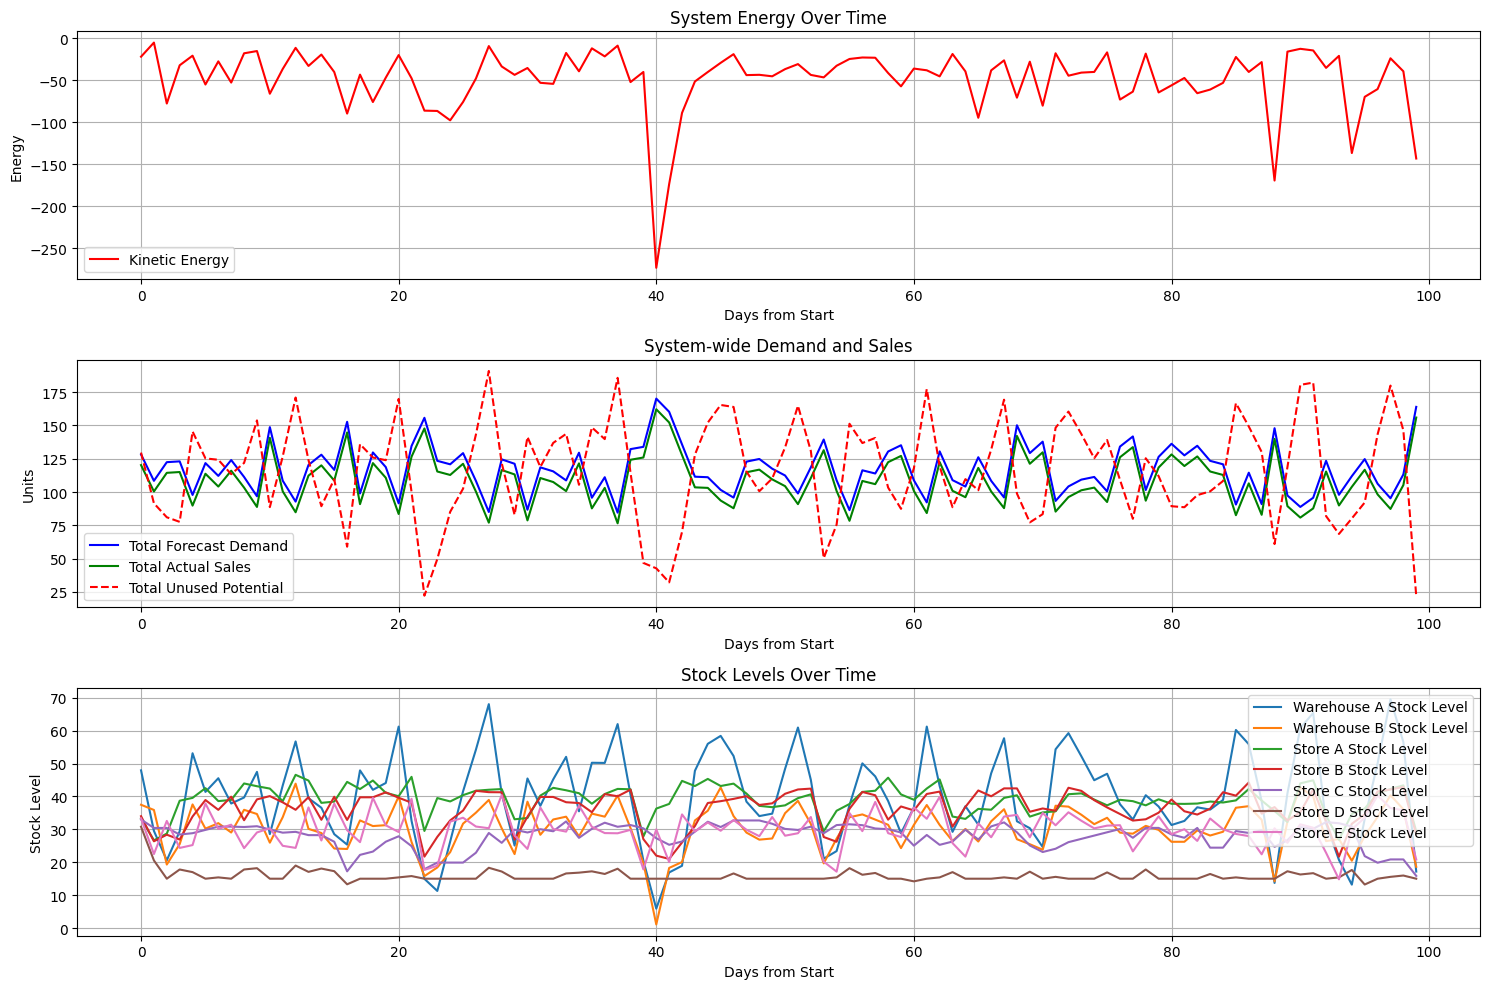

In [204]:
index = pd.date_range(start='2023-01-01', periods=100, freq='D')

N = 100
# Example input data
warehouse_df = pd.DataFrame({
    'stock_level': [100] * N,
    'forecast_demand': forecasted_demand,
    'actual_sales': forecasted_demand - 1,
    'reorder_point': [60] * N,
    'target_stock': [100] * N,
    'replenishment_lead_time': [2] * N  # 2 days to receive new stock
}, index=index)

warehouse_b_df = pd.DataFrame({
    'stock_level': [80] * N,
    'forecast_demand': forecasted_demand2+forecasted_demand3,
    'actual_sales': (forecasted_demand2 - 1)+(forecasted_demand3 - 1),
    'reorder_point': [50] * N,  # Order when stock falls below 50
    'target_stock': [80] * N,   # Restock to 80
    'replenishment_lead_time': [1] * N  # 1 day to receive new stock
}, index=index)

retail_store_a_df = pd.DataFrame({
    'stock_level': [30] * N,
    'forecast_demand': forecasted_demand,
    'actual_sales': forecasted_demand - 1,
}, index=index)

retail_store_b_df = pd.DataFrame({
    'stock_level': [30] * N,
    'forecast_demand': forecasted_demand2,
    'actual_sales': forecasted_demand2 - 1,
}, index=index)

retail_store_c_df = pd.DataFrame({
    'stock_level': [35] * N,
    'forecast_demand': forecasted_demand3,
    'actual_sales': forecasted_demand3 - 1,
}, index=index)

retail_store_d_df = pd.DataFrame({
    'stock_level': [50] * N,
    'forecast_demand': forecasted_demand2*1.2,
    'actual_sales': forecasted_demand2*1.2 - 1,
}, index=index)

retail_store_e_df = pd.DataFrame({
    'stock_level': [45] * N,
    'forecast_demand': forecasted_demand3*1.1,
    'actual_sales': forecasted_demand3*1.1 - 1,
}, index=index)

# Create nodes
nodes = {
    'Warehouse A': SupplyChainNode2('Warehouse A', warehouse_df),
    'Warehouse B': SupplyChainNode2('Warehouse B', warehouse_b_df),
    'Store A': SupplyChainNode2("Store A", retail_store_a_df),
    'Store B': SupplyChainNode2('Store B', retail_store_b_df),
    'Store C': SupplyChainNode2('Store C', retail_store_c_df),
    'Store D': SupplyChainNode2('Store D', retail_store_d_df),
    'Store E': SupplyChainNode2('Store E', retail_store_e_df)

}

# Define edges
edges = {
    ('Warehouse A', 'Store A'): {'potential': 0.4, 'max_flow_rate': 25},
    ('Warehouse A', 'Store B'): {'potential': 0.5, 'max_flow_rate': 20},
    ("Warehouse B", 'Store C'): {'potential': 0.6, 'max_flow_rate': 15},
    ("Warehouse B", 'Store D'): {'potential': 0.1, 'max_flow_rate': 15},
    ("Warehouse A", 'Store E'): {'potential': 0.2, 'max_flow_rate': 30},
    ('Warehouse A', 'Warehouse B'): {'potential': 0.15, 'max_flow_rate': 15}
}

# Create and simulate network
network = SupplyChainNetwork2(nodes, edges)
network.simulate_flow()

In [205]:
store_df = network.get_filtered_metrics("store")
store_df

,forecast_demand,actual_sales,unused_potential,total_stock,Store A_stock,Store A_forecast,Store A_sales,Store A_unused,Store B_stock,Store B_forecast,...,Store C_sales,Store C_unused,Store D_stock,Store D_forecast,Store D_sales,Store D_unused,Store E_stock,Store E_forecast,Store E_sales,Store E_unused
2023-01-01,84.2,79.2,85.194588,164.394588,33.287335,9,8,25.287335,34.0,17,...,17,16.0,30.798346,20.4,19.4,11.398346,33.308907,19.8,18.8,14.508907
2023-01-02,70.4,65.4,61.110335,126.510335,26.668215,10,9,17.668215,26.372334,16,...,11,19.426465,20.551752,19.2,18.2,2.351752,22.491569,13.2,12.2,10.291569
2023-01-03,81.4,76.4,65.462451,135.062451,28.699908,6,5,23.699908,28.372334,19,...,15,15.426465,15.0,22.8,21.8,0,32.563744,17.6,16.6,15.963744
2023-01-04,78.0,73.0,63.187746,136.187746,38.699908,16,15,23.699908,26.909489,11,...,17,11.426465,17.8,13.2,12.2,5.6,24.351884,19.8,18.8,5.551884
2023-01-05,62.8,57.8,86.722226,144.522226,39.56188,11,10,29.56188,33.909489,14,...,9,19.830769,17.0,16.8,15.8,1.2,25.220089,11.0,10.0,15.220089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-06,82.7,77.7,63.925709,139.484505,36.340633,6,5,31.340633,34.551403,11,...,24,0,13.233673,13.2,12.2,1.033673,33.5,27.5,26.5,7.0
2023-04-07,70.2,65.2,92.390626,157.590626,40.858219,6,5,35.858219,41.530716,12,...,17,2.858796,15.0,14.4,13.4,1.6,40.342895,19.8,18.8,21.542895
2023-04-08,61.3,56.3,100.964575,157.264575,42.276385,10,9,33.276385,42.094808,9,...,14,6.858796,15.564516,10.8,9.8,5.764516,36.470069,16.5,15.5,20.970069
2023-04-09,73.2,68.2,90.667685,158.867685,43.368782,11,10,33.368782,42.889232,13,...,15,5.858796,15.964516,15.6,14.6,1.364516,35.786358,17.6,16.6,19.186358


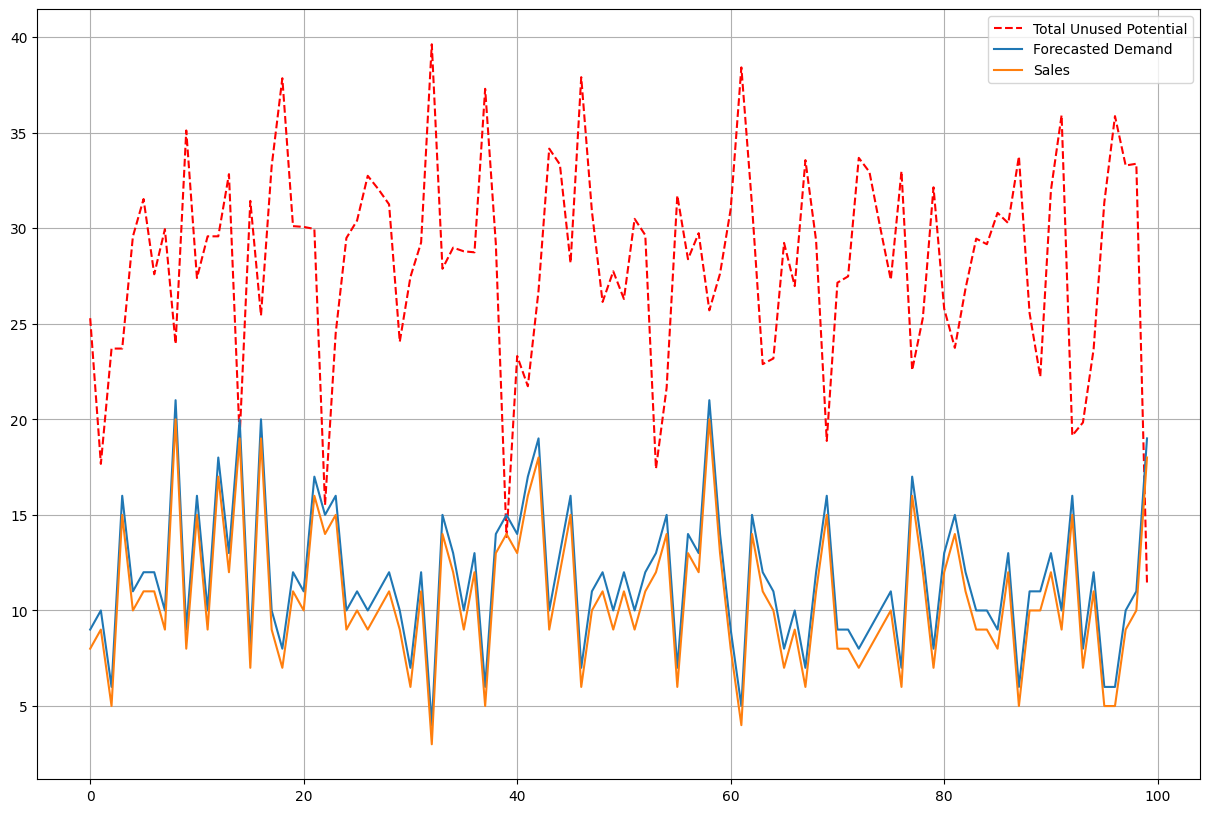

In [206]:
plt.figure(figsize=(15,10))

plt.plot(range(len(store_df)), store_df["Store A_unused"], label="Total Unused Potential", linestyle="--", color="r")
plt.plot(range(len(store_df)), store_df["Store A_forecast"], label="Forecasted Demand")
plt.plot(range(len(store_df)), store_df["Store A_sales"], label="Sales")

plt.legend()
plt.grid(True)

C:\Users\jako\AppData\Local\Temp\ipykernel_25244\2782547137.py:20: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



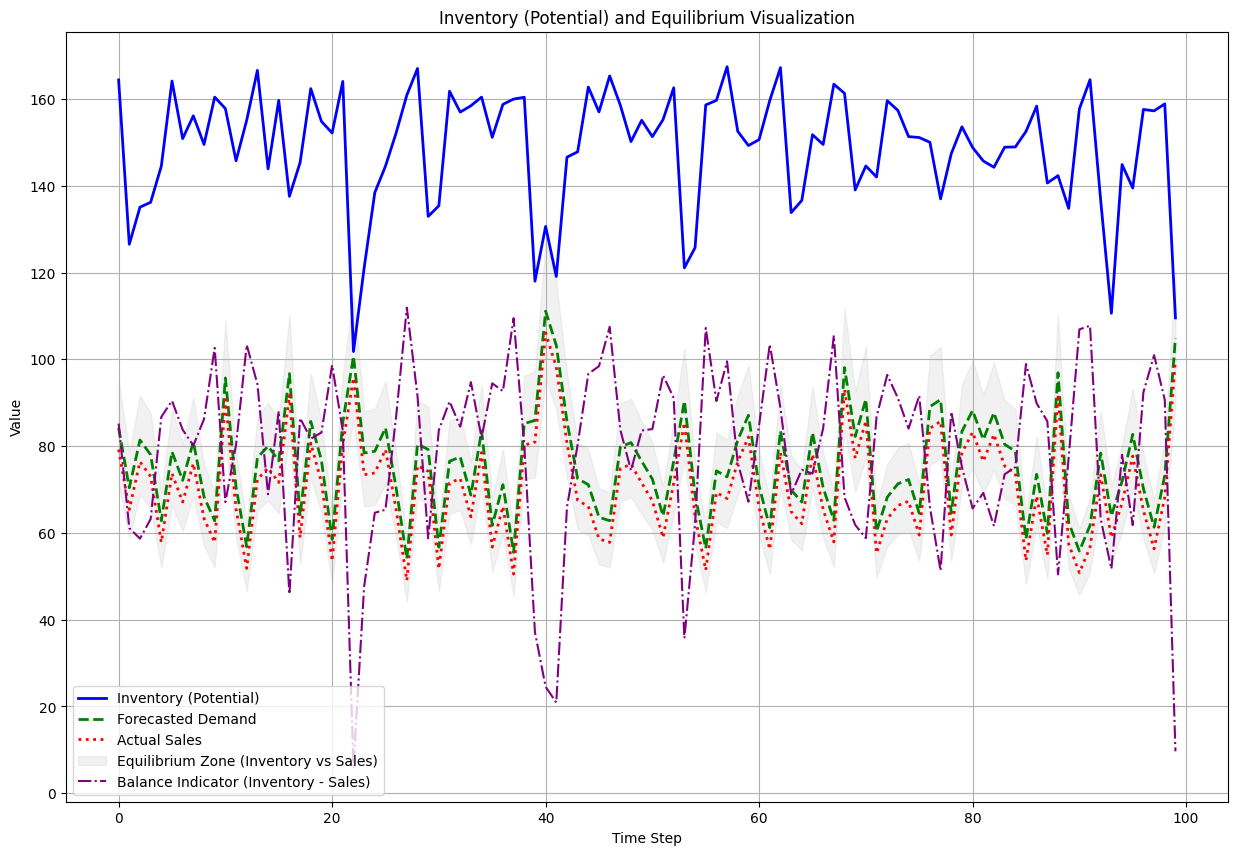

In [208]:
plt.figure(figsize=(15, 10))

# Plotting inventory (potential), forecasted demand, and actual sales
plt.plot(range(len(store_df)), store_df["total_stock"], label="Inventory (Potential)", linestyle="-", color="b", linewidth=2)
plt.plot(range(len(store_df)), store_df["forecast_demand"], label="Forecasted Demand", linestyle="--", color="g", linewidth=2)
plt.plot(range(len(store_df)), store_df["actual_sales"], label="Actual Sales", linestyle=":", color="r", linewidth=2)

# Adding a shaded "balanced zone" to indicate equilibrium conditions
plt.fill_between(range(len(store_df)),
                 store_df["actual_sales"] * 0.9,  # Lower limit - Inventory should ideally be just above actual sales
                 store_df["actual_sales"] * 1.2,  # Upper limit - Inventory should ideally not be much higher
                 color='lightgrey', alpha=0.3, label='Equilibrium Zone (Inventory vs Sales)')

# Calculate and plot the difference between inventory and actual sales
balance_indicator = store_df["total_stock"] - store_df["actual_sales"]
plt.plot(range(len(store_df)), balance_indicator, label="Balance Indicator (Inventory - Sales)", linestyle="-.", color="purple", linewidth=1.5)

# Annotate points where inventory matches actual sales closely (equilibrium)
for i in range(len(store_df)):
    if abs(balance_indicator[i]) < 0.05 * store_df["actual_sales"][i]:
        plt.scatter(i, store_df["actual_sales"][i], color='gold', s=100, edgecolor='black', zorder=5, label='Equilibrium Point' if i == 0 else "")

# Final Plot Customization
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Inventory (Potential) and Equilibrium Visualization")
plt.legend()
plt.grid(True)
plt.show()


In [209]:
store_df.info()

store_df["total_stock"] = store_df["total_stock"].astype(float)
store_df["unused_potential"] = store_df["unused_potential"].astype(float)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2023-01-01 to 2023-04-10
Freq: D
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   forecast_demand   100 non-null    float64
 1   actual_sales      100 non-null    float64
 2   unused_potential  100 non-null    object 
 3   total_stock       100 non-null    object 
 4   Store A_stock     100 non-null    object 
 5   Store A_forecast  100 non-null    int32  
 6   Store A_sales     100 non-null    int32  
 7   Store A_unused    100 non-null    object 
 8   Store B_stock     100 non-null    object 
 9   Store B_forecast  100 non-null    int32  
 10  Store B_sales     100 non-null    int32  
 11  Store B_unused    100 non-null    object 
 12  Store C_stock     100 non-null    object 
 13  Store C_forecast  100 non-null    int32  
 14  Store C_sales     100 non-null    int32  
 15  Store C_unused    100 non-null    object 
 16  Store D_stock    

In [82]:
store_df

,forecast_demand,actual_sales,unused_potential,total_stock,Retail Store C_stock,Retail Store C_forecast,Retail Store C_sales,Retail Store C_unused
2023-01-01,14,13,31.996584,44.996584,44.996584,14,13,31.996584
2023-01-02,10,9,31.396988,40.396988,40.396988,10,9,31.396988
2023-01-03,13,12,20.171768,32.171768,32.171768,13,12,20.171768
2023-01-04,6,5,33.307402,38.307402,38.307402,6,5,33.307402
2023-01-05,18,17,30.578568,47.578568,47.578568,18,17,30.578568
2023-01-06,7,6,40.802617,46.802617,46.802617,7,6,40.802617
2023-01-07,12,11,29.358435,40.358435,40.358435,12,11,29.358435
2023-01-08,10,9,30.072337,39.072337,39.072337,10,9,30.072337
2023-01-09,11,10,29.354117,39.354117,39.354117,11,10,29.354117
2023-01-10,17,16,29.995240,45.995240,45.99524,17,16,29.99524


In [83]:
(store_df["unused_potential"].shift(1) - store_df.actual_sales).fillna(store_df["unused_potential"][0].copy())

C:\Users\jako\AppData\Local\Temp\ipykernel_25244\3269277989.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (store_df["unused_potential"].shift(1) - store_df.actual_sales).fillna(store_df["unused_potential"][0].copy())


2023-01-01    31.996584
2023-01-02    22.996584
2023-01-03    19.396988
2023-01-04    15.171768
2023-01-05    16.307402
2023-01-06    24.578568
2023-01-07    29.802617
2023-01-08    20.358435
2023-01-09    20.072337
2023-01-10    13.354117
Freq: D, dtype: float64

C:\Users\jako\AppData\Local\Temp\ipykernel_25244\3745647747.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  balance_indicator = (store_df["total_stock"].shift(1) - store_df.actual_sales).fillna(store_df["total_stock"][0].copy())
C:\Users\jako\AppData\Local\Temp\ipykernel_25244\3745647747.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if balance_indicator[i] == 0:


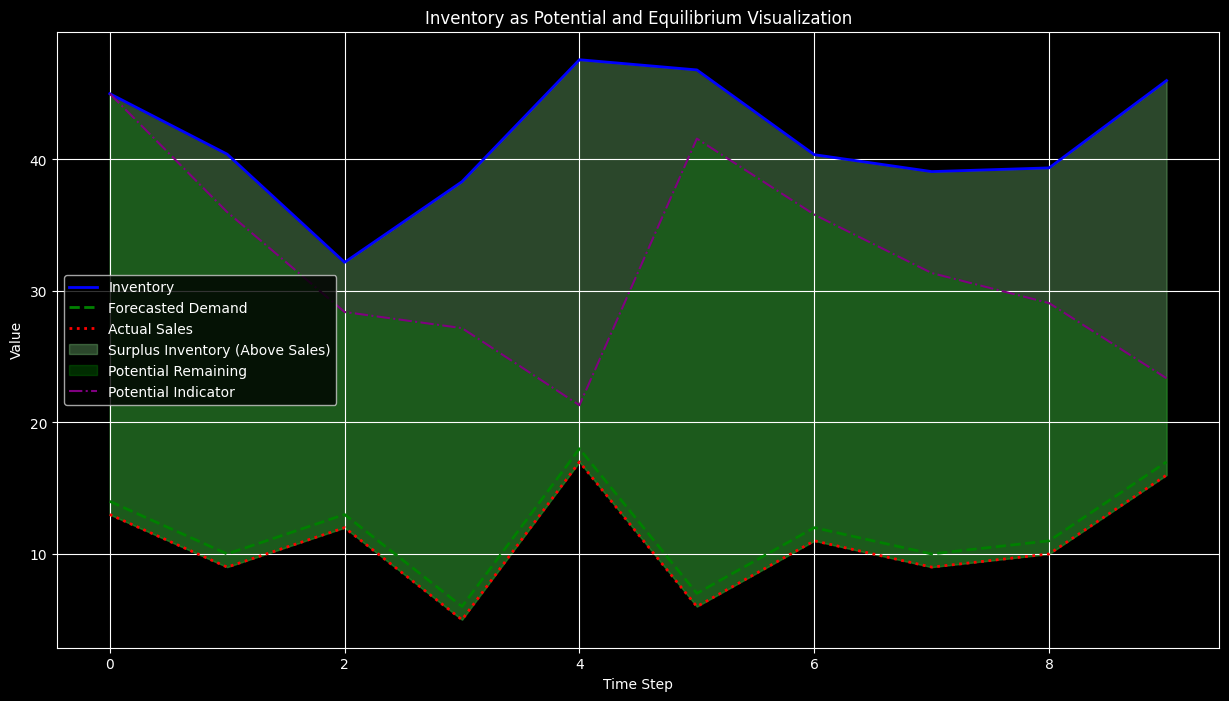

In [84]:
plt.figure(figsize=(15, 8))

# Plotting inventory, forecasted demand, and actual sales
plt.plot(range(len(store_df)), store_df["total_stock"], label="Inventory", linestyle="-", color="b", linewidth=2)
plt.plot(range(len(store_df)), store_df["forecast_demand"], label="Forecasted Demand", linestyle="--", color="g", linewidth=2)
plt.plot(range(len(store_df)), store_df["actual_sales"], label="Actual Sales", linestyle=":", color="r", linewidth=2)

# Calculate the balance indicator: Difference between inventory and actual sales
balance_indicator = (store_df["total_stock"].shift(1) - store_df.actual_sales).fillna(store_df["total_stock"][0].copy())
second_balance = store_df["unused_potential"] - store_df.actual_sales

# Shading the region between actual sales and inventory
plt.fill_between(range(len(store_df)),
                 store_df["actual_sales"], store_df["total_stock"],
                 where=(store_df["total_stock"] >= store_df["actual_sales"]),
                 interpolate=True, color='lightgreen', alpha=0.3, label='Surplus Inventory (Above Sales)')



plt.fill_between(range(len(store_df)),
                 store_df["actual_sales"], balance_indicator,
                 where=(balance_indicator >= store_df["actual_sales"]),
                 interpolate=True, color='green', alpha=0.35, label='Potential Remaining')


# Plot the balance indicator: Difference between inventory and actual sales
plt.plot(range(len(store_df)), balance_indicator, label="Potential Indicator", linestyle="-.", color="purple", linewidth=1.5)


# Annotate points where inventory exactly matches actual sales (equilibrium)
for i in range(len(store_df)):
    if balance_indicator[i] == 0:
        plt.scatter(i, store_df["actual_sales"][i], color='gold', s=100, edgecolor='black', zorder=5, label='Equilibrium Point' if i == 0 else "")



# Adding grid lines, labels, and legend for better visualization
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Inventory as Potential and Equilibrium Visualization")
plt.legend()
plt.grid(True)
plt.show()


In [85]:
import seaborn as sns
store_df

,forecast_demand,actual_sales,unused_potential,total_stock,Retail Store C_stock,Retail Store C_forecast,Retail Store C_sales,Retail Store C_unused
2023-01-01,14,13,31.996584,44.996584,44.996584,14,13,31.996584
2023-01-02,10,9,31.396988,40.396988,40.396988,10,9,31.396988
2023-01-03,13,12,20.171768,32.171768,32.171768,13,12,20.171768
2023-01-04,6,5,33.307402,38.307402,38.307402,6,5,33.307402
2023-01-05,18,17,30.578568,47.578568,47.578568,18,17,30.578568
2023-01-06,7,6,40.802617,46.802617,46.802617,7,6,40.802617
2023-01-07,12,11,29.358435,40.358435,40.358435,12,11,29.358435
2023-01-08,10,9,30.072337,39.072337,39.072337,10,9,30.072337
2023-01-09,11,10,29.354117,39.354117,39.354117,11,10,29.354117
2023-01-10,17,16,29.995240,45.995240,45.99524,17,16,29.99524


Text(0, 0.5, 'Unused Potential')

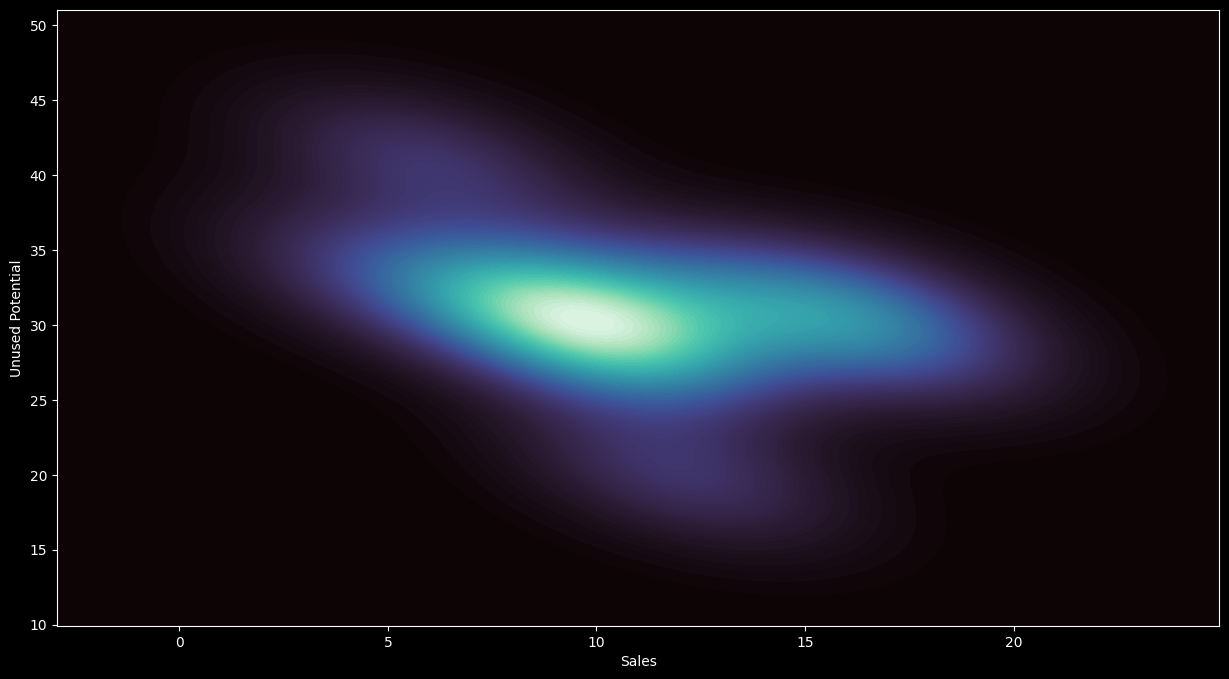

In [86]:
# sns.set(style="ticks", context="talk")
plt.style.use("dark_background")


plt.figure(figsize=(15, 8))

sns.kdeplot(data=store_df,
            x="actual_sales",
            y="unused_potential",
            fill=True, thresh=0, levels=100, cmap="mako")

plt.xlabel("Sales")
plt.ylabel("Unused Potential")

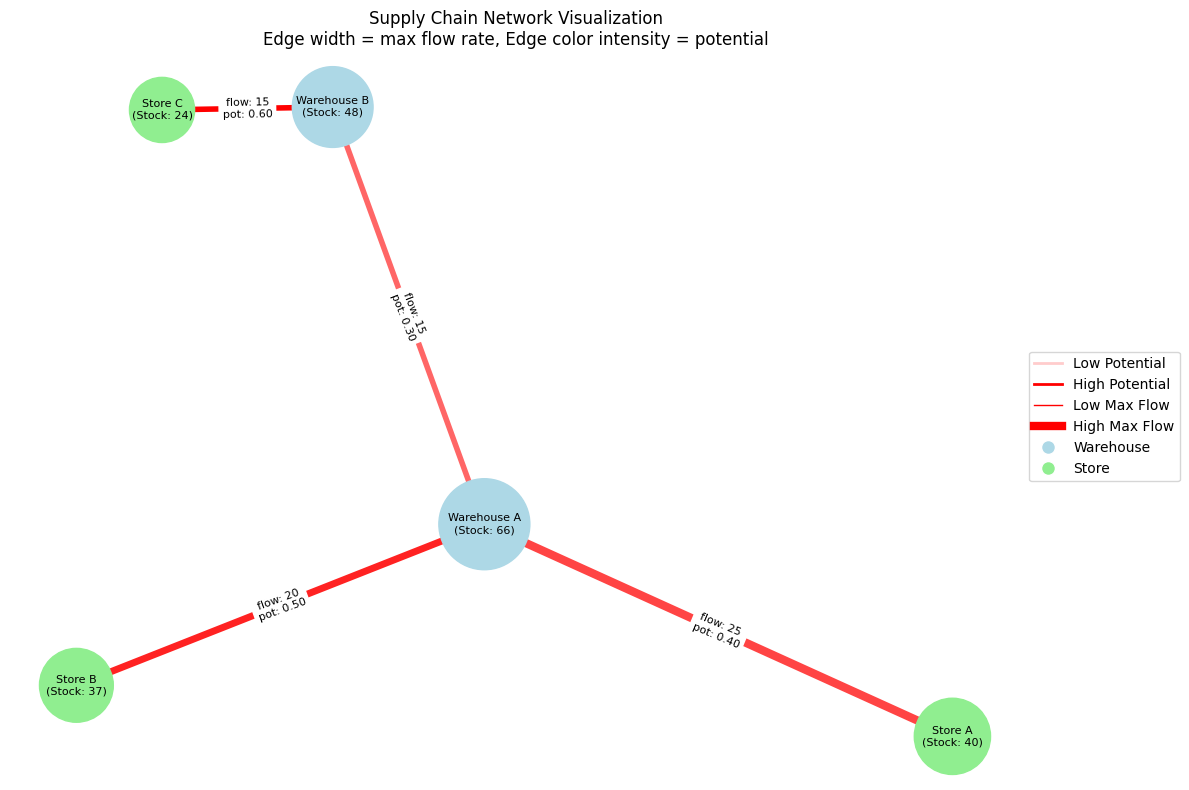

In [122]:
import networkx as nx
network.visualize_network()

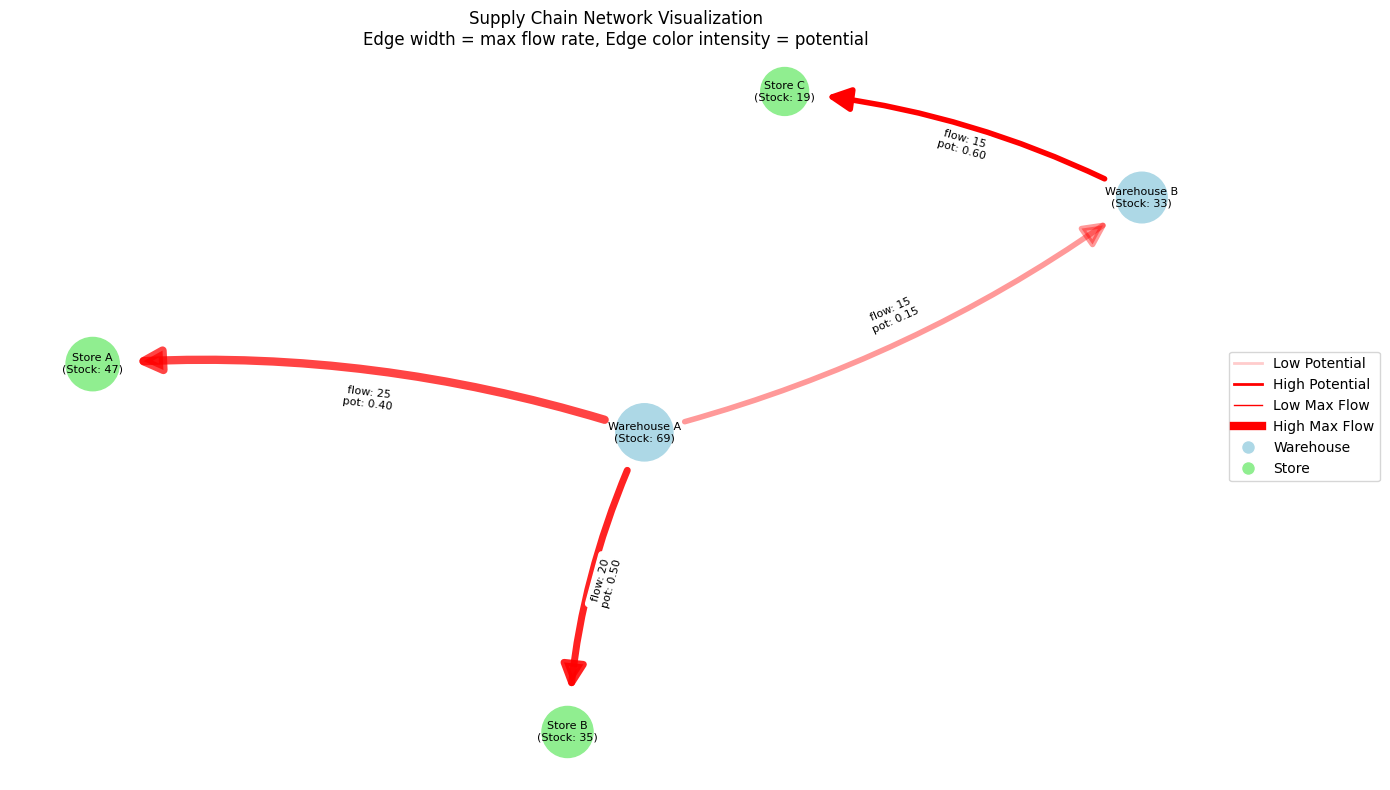

In [162]:
plt.style.use("default")


network.visualize_network()


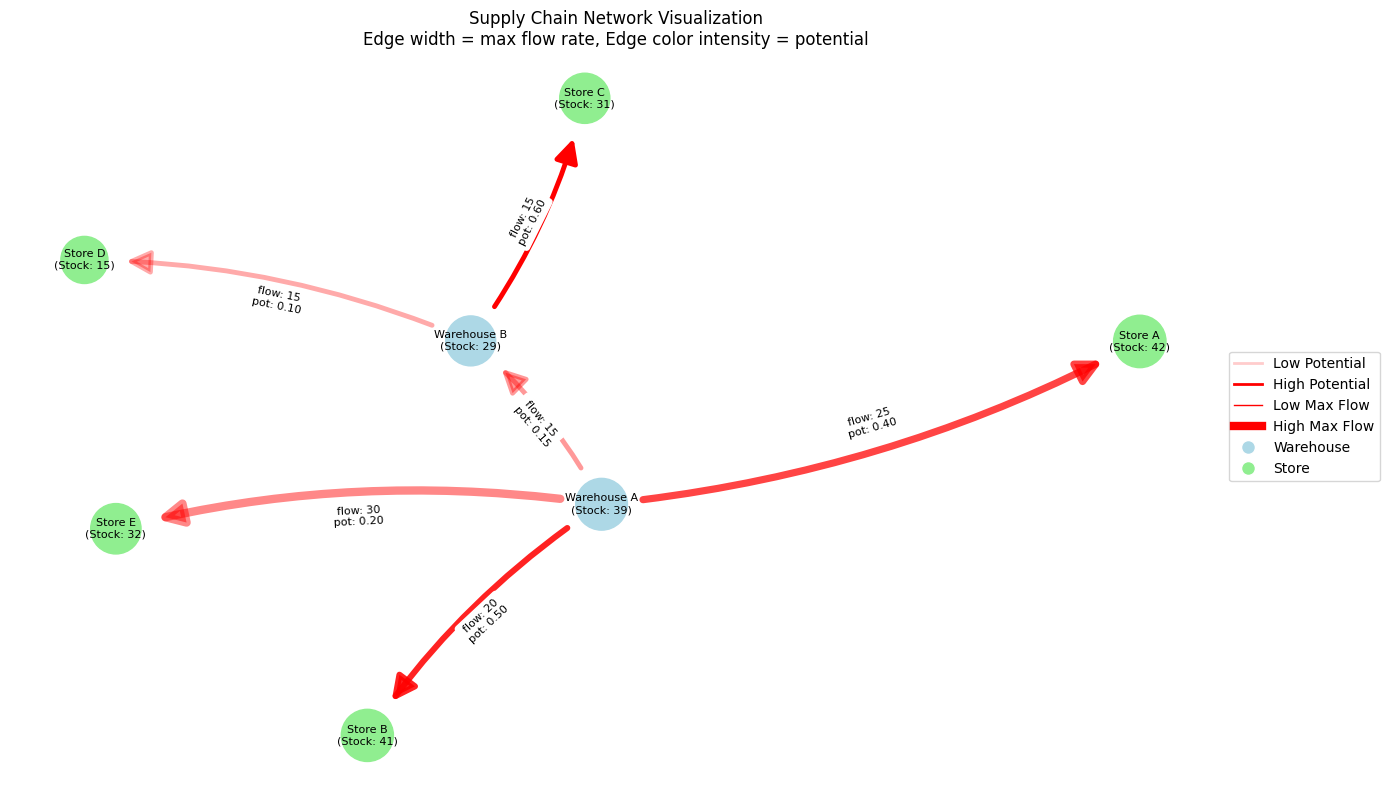

In [169]:
plt.style.use("default")


network.visualize_network()


In [194]:
import plotly.express as px
import plotly.graph_objects as go

In [195]:
store_df.columns

Index(['forecast_demand', 'actual_sales', 'unused_potential', 'total_stock',
       'Store A_stock', 'Store A_forecast', 'Store A_sales', 'Store A_unused',
       'Store B_stock', 'Store B_forecast', 'Store B_sales', 'Store B_unused',
       'Store C_stock', 'Store C_forecast', 'Store C_sales', 'Store C_unused',
       'Store D_stock', 'Store D_forecast', 'Store D_sales', 'Store D_unused',
       'Store E_stock', 'Store E_forecast', 'Store E_sales', 'Store E_unused'],
      dtype='object')

In [210]:
fig = px.scatter_3d(
    store_df,
    x="Store A_stock", y="Store A_forecast", z="Store A_unused"
)

fig.show()